# Simulation and Inference of Interferometry on Growing Thin Films

We are interested in sumulating the reflectance of growing thin films (forward modeling) and infer the growth behavior from measurements.

Caution: This is work in progress.

## Imports

In [20]:
# numerics
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import optax

# data reading
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# our library
from reflax import polanalyze, variable_layer_thickness_simulation
from reflax.parameter_classes.parameters import OpticsParams, SetupParams, LayerParams, GrowthModel
from reflax.forward_model.variable_layer_size import power_forward_model
from reflax.data_analysis import cws

## Simulation

### General Setup

Let us first specify parameters of the experimental setup

In [21]:
from reflax.parameter_classes.parameters import SetupParams

wavelength = 632.8
polar_angle = jnp.deg2rad(25)
azimuthal_angle = jnp.deg2rad(0)

setup_params = SetupParams(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle
)

polarization_state = "Linear TE/perpendicular/s"
transverse_electric_component, transverse_magnetic_component = polanalyze(polarization_state)

We also generally assume

In [22]:
permeability_reflection = 1
permittivity_reflection = 1

permeability_transmission = 1
permittivity_transmission = (3.8827 + 0.019626j)**2

optics_params = OpticsParams(
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component
)

backside_mode = 1

and consider a setup with two static-thickness layers with parameters

In [23]:
static_layer_thicknesses = jnp.array([10.0])
permeability_static_size_layers = jnp.array([1.0])
permittivity_static_size_layers = jnp.array([1.45704**2])

static_layer_params = LayerParams(
    permeabilities = permeability_static_size_layers,
    permittivities = permittivity_static_size_layers,
    thicknesses = static_layer_thicknesses
)

Let there further be a layer of variable thickness, with properties

In [24]:
permeability_variable_layer = 1
permittivity_variable_layer = 1.57**2

variable_layer_params = LayerParams(
    permeabilities = permeability_variable_layer,
    permittivities = permittivity_variable_layer
)

### Growth model for the variable layer

We simulate over the timespan

In [25]:
final_time = 7049
time_points = jnp.arange(0, final_time)

Given a linear growth rate

In [26]:
layer_growing_rate = 747.9 / (7049 / 60) / 60

this yields the following thicknesses of the variable layer

In [27]:
variable_layer_thicknesses = time_points * layer_growing_rate

### Running the simulation

In [28]:
reflection_coefficients, transmission_coefficients, conservation_checks = variable_layer_thickness_simulation(
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = variable_layer_thicknesses,
    backside_mode = backside_mode
)

### Profiling the simulation

In [29]:
%%timeit
reflection_coefficients, transmission_coefficients, conservation_checks = jax.block_until_ready(variable_layer_thickness_simulation(
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = variable_layer_thicknesses,
    backside_mode = backside_mode
))

3.63 ms ± 30.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Interactive Plotting

In [41]:
from ipywidgets import interact
import ipywidgets as widgets

from reflax.forward_model.variable_layer_size import normalized_forward_model

initial_layer_thickness = 70
layer_growing_acceleration = 5e-7

@interact(model = widgets.IntSlider(min=0, max=4, step=1, value=1))
def int_plot(model):
    model = normalized_forward_model(
        model = model,
        setup_params = setup_params,
        optics_params = optics_params,
        static_layer_params = static_layer_params,
        variable_layer_params = variable_layer_params,
        variable_layer_thicknesses = initial_layer_thickness + layer_growing_rate * time_points + 1/2 * layer_growing_acceleration * time_points ** 2,
        backside_mode = backside_mode
    )
    plt.plot(time_points, model * 100, '-g', linewidth=1, label="model")
    plt.xlabel("Time in s")
    plt.legend(loc="upper right")

interactive(children=(IntSlider(value=1, description='model', max=5), Output()), _dom_classes=('widget-interac…

## Data Analysis

Text(0.5, 1.0, 'measurement')

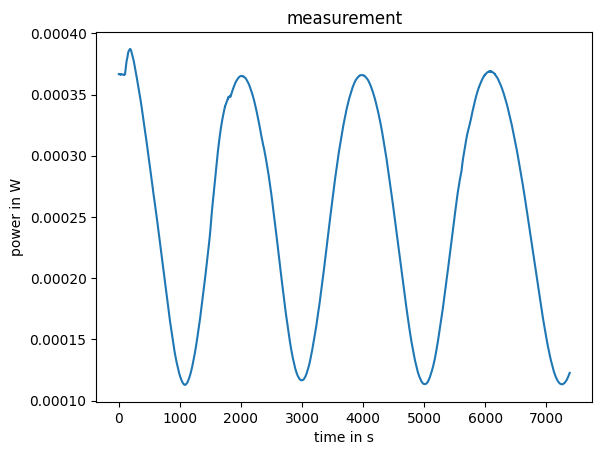

In [31]:
# Define the CSV file path
file_path = 'data/measurement.csv'

# Read the CSV, skipping rows until the data table starts
df = pd.read_csv(file_path, sep=';', skiprows=14, decimal=',')
df.columns = df.columns.str.strip()

# Strip whitespace and convert to datetime objects
df['Time'] = pd.to_datetime(df['Time of day (hh:mm:ss)'].str.strip(), format='%H:%M:%S.%f')

# Calculate time since the start
start_time = df['Time'].iloc[0]
df['Time Since Start (seconds)'] = (df['Time'] - start_time).dt.total_seconds()

# Save as jnp arrays
time_points_measured = jnp.asarray(df['Time Since Start (seconds)'])
power_measured = jnp.asarray(df["Power (W)"])

# Display the result
plt.plot(time_points_measured, power_measured)
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("measurement")


There seem to be artefacts in the measurement at the beginning up until ~1800 seconds (see the non-smooth transition there). We will cut this part of the measurement away.

In [32]:
time_points_measured = time_points_measured[300:] - time_points_measured[300]
power_measured = power_measured[300:]

Which looks much better

Text(0.5, 1.0, 'cleaned measurement')

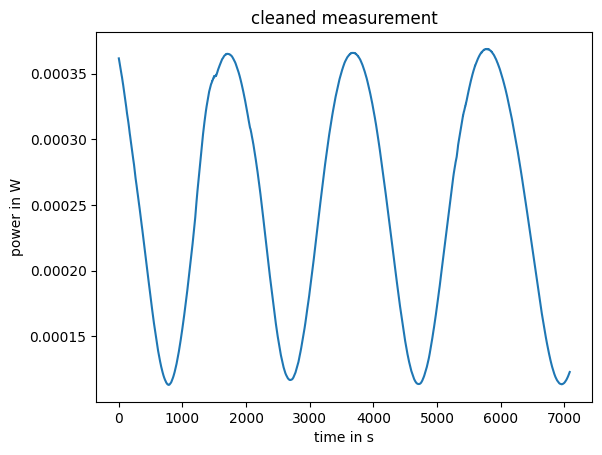

In [33]:
plt.plot(time_points_measured, power_measured)
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("cleaned measurement")

### Wavelet analysis

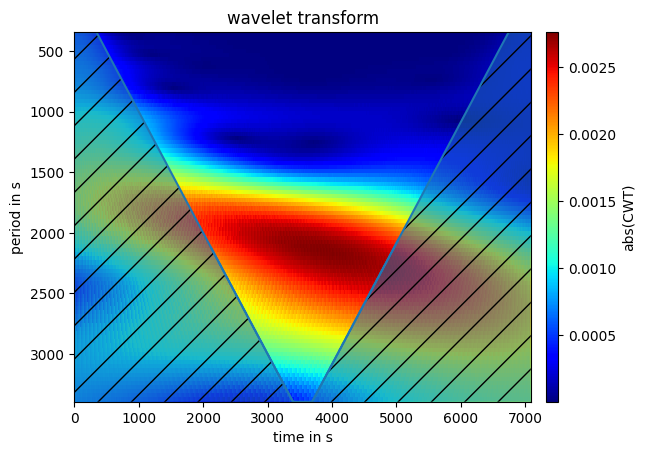

In [34]:
def plot_scaleogram(ax, time_points, signal, title, ylabel = "period in s", xlabel = "time in s", cbarlabel = "abs(CWT)", yscale = "linear", cscale = "linear", scales = np.arange(10, 1000, 10), clim = None, coi=True): # scales = np.arange(100, 2200, 20)
    cws(time = time_points, signal = signal, ax = ax, scales = scales, wavelet="cmor1-1.5", coikw={'alpha':0.5,'hatch':'/'}, ylabel = ylabel, xlabel = xlabel, title = title, cscale = cscale, yscale = yscale, cbarlabel = cbarlabel, clim = clim, coi=coi)

fig, ax = plt.subplots()
plot_scaleogram(ax, time_points_measured, power_measured, "wavelet transform", scales = np.arange(500, 5000, 50), coi=True)


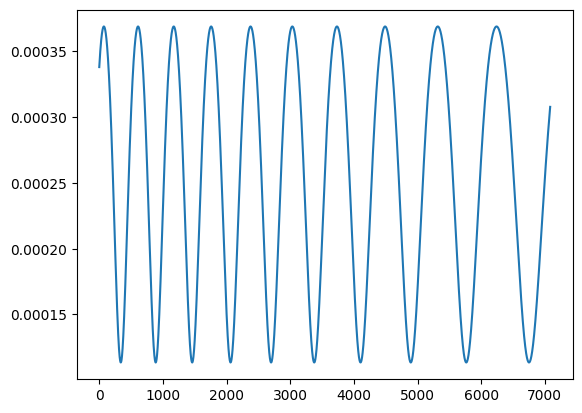

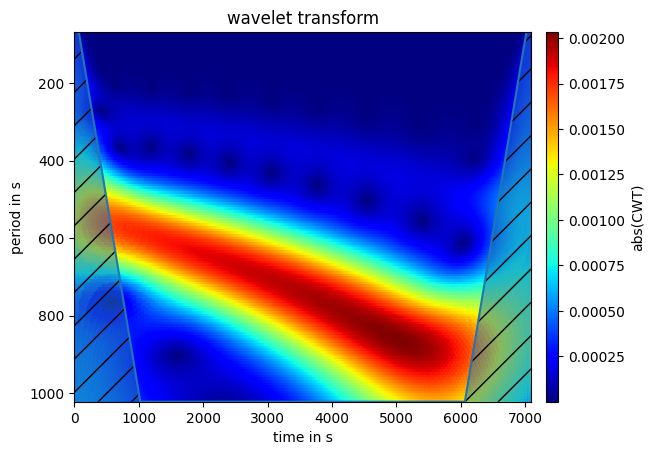

In [35]:
initial_layer_thickness = 170
layer_growing_rate = 0.4
layer_growing_acceleration = -3e-5

growth_model = GrowthModel(
    initial_thickness = initial_layer_thickness,
    growth_velocity = layer_growing_rate,
    growth_acceleration = layer_growing_acceleration
)

power_conversion_factor = 0.00075
power_conversion_constant = 0.00008

power_simulated = power_forward_model(
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    timepoints_measured = time_points_measured,
    growth_model = growth_model,
    power_conversion_factor = power_conversion_factor,
    power_conversion_constant = power_conversion_constant,
    backside_mode = backside_mode
)

plt.plot(time_points_measured, power_simulated)

fig, ax = plt.subplots()
plot_scaleogram(ax, time_points_measured, power_simulated, "wavelet transform", scales = np.arange(100, 1500, 10), coi=True)

## Inference

### Inference by hand

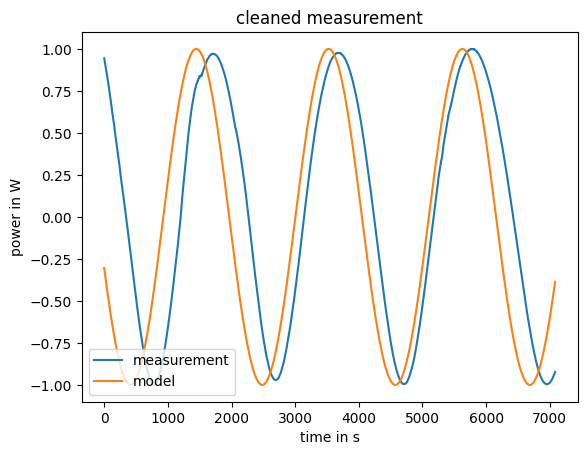

In [36]:
from reflax import power_forward_residuals
from reflax.forward_model.variable_layer_size import normalized_forward_model
# initial_layer_thickness = 170
# layer_growing_rate = 747.9 / (7049 / 60) / 60
# layer_growing_acceleration = -0.0000004

# 1.7000000e+02  1.0696702e-01 -5.1498353e-07
# 1.07924394e-01 -6.79976267e-07

initial_layer_thickness = 70
layer_growing_rate = 1.0696702e-01
layer_growing_acceleration = -5.1498353e-07

# initial_layer_thickness = 275
# layer_growing_rate = 0.7e-01
# layer_growing_acceleration = -13e-07
# layer_growing_acceleration = 0

permeability_variable_layer = 1
permittivity_variable_layer = 1.50**2

variable_layer_params = LayerParams(
    permeabilities = permeability_variable_layer,
    permittivities = permittivity_variable_layer
)

# simple accelerated model
layer_thickness_model = initial_layer_thickness + layer_growing_rate * time_points_measured + layer_growing_acceleration * time_points_measured ** 2

power_model_z = normalized_forward_model(
        model = 2,
        setup_params = setup_params,
        optics_params = optics_params,
        static_layer_params = static_layer_params,
        variable_layer_params = variable_layer_params._replace(permittivities = permittivity_variable_layer),
        variable_layer_thicknesses = initial_layer_thickness + layer_growing_rate * time_points_measured + 1/2 * layer_growing_acceleration * time_points_measured ** 2,
        backside_mode = backside_mode
)

power_measured_z = (power_measured - 0.5 * (jnp.min(power_measured) + jnp.max(power_measured))) / (0.5 * (jnp.max(power_measured) - jnp.min(power_measured)))


plt.plot(time_points_measured, power_measured_z, label = "measurement")
plt.plot(time_points_measured, power_model_z, label = "model")
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("cleaned measurement")
plt.legend(loc = "lower left")

### Computational optimization

Thickness Results Model I
14.062091119186443
780.2013125657788
Thickness Results Model II
15.553685827471543
782.3919226167013
Thickness Results Model III
18.294762701956373
784.43392737036
Thickness Results Model IV
12.352530352675466
778.3463214399412
Thickness Results Model V
8.029174804839297
776.0234479157069


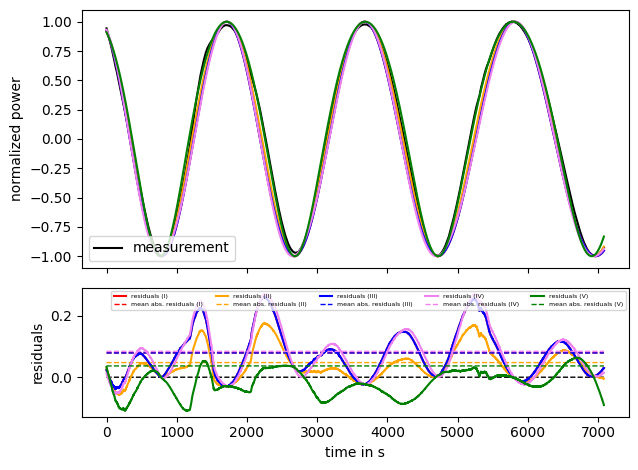

In [37]:
from reflax import power_forward_residuals
from reflax.forward_model.variable_layer_size import normalized_forward_model
import optimistix as optx

initial_guess_x = jnp.array([initial_layer_thickness, layer_growing_rate, layer_growing_acceleration])
power_measured_z = (power_measured - 0.5 * (jnp.min(power_measured) + jnp.max(power_measured))) / (0.5 * (jnp.max(power_measured) - jnp.min(power_measured)))

# init plot
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
ax1.plot(time_points_measured, power_measured_z, label="measurement", color="black")

ax1.legend(loc="lower left")
ax1.set_ylabel("normalized power")

ax2.set_xlabel("time in s")
ax2.set_ylabel("residuals")

ax2.plot(time_points_measured, jnp.zeros_like(time_points_measured), '--k', linewidth=1)

# ========================== Optim. and Residuals ==========================

def optim_and_res(model, model_str, color):

    def residuals(params, consts):
        initial_thickness, growth_velocity, growth_acceleration = params * initial_guess_x
        power_model_z = normalized_forward_model(
            model,
            setup_params = setup_params,
            optics_params = optics_params,
            static_layer_params = static_layer_params,
            variable_layer_params = variable_layer_params, # ._replace(permittivities = variable_layer_permittivity),
            variable_layer_thicknesses = initial_thickness + growth_velocity * time_points_measured + 1/2 * growth_acceleration * time_points_measured ** 2,
            backside_mode = backside_mode
        )

        residuals = power_measured_z - power_model_z

        return residuals

    initial_guess = jnp.array([1.0, 1.0, 1.0])

    solver = optx.LevenbergMarquardt(
        rtol=1e-8, atol=1e-8
    )

    sol = optx.least_squares(residuals, solver, initial_guess).value

    initial_thickness, growth_velocity, growth_acceleration = sol * initial_guess_x

    final_thickness = initial_thickness + growth_velocity * time_points_measured[-1] + 1/2 * growth_acceleration * time_points_measured[-1] ** 2

    print("Thickness Results Model " + model_str)
    print(initial_thickness)
    print(final_thickness)

    power_model_z = normalized_forward_model(
            model,
            setup_params = setup_params,
            optics_params = optics_params,
            static_layer_params = static_layer_params,
            variable_layer_params = variable_layer_params, # ._replace(permittivities = variable_layer_permittivity),
            variable_layer_thicknesses = initial_thickness + growth_velocity * time_points_measured + 1/2 * growth_acceleration * time_points_measured ** 2,
            backside_mode = backside_mode
    )

    ax1.plot(time_points_measured, power_model_z, label="model, one layer, no reflections ({})".format(model_str), color=color)

    residuals_model_z = power_measured_z - power_model_z

    ax2.plot(time_points_measured, residuals_model_z, label="residuals ({})".format(model_str), color=color)
    ax2.plot(time_points_measured, jnp.mean(jnp.abs(residuals_model_z)) * jnp.ones_like(time_points_measured), '--', linewidth=1, label="mean abs. residuals ({})".format(model_str), color = color)

# ============================================================================

optim_and_res(0, "I", "red")
optim_and_res(1, "II", "orange")
optim_and_res(2, "III", "blue")
optim_and_res(3, "IV", "violet")
optim_and_res(4, "V", "green")
num_models = 5

ax2.legend(loc="upper right", ncol=num_models, fontsize=4.5)
plt.tight_layout()
plt.show()

# save plot as high res png
fig.savefig("res.png", dpi=300)

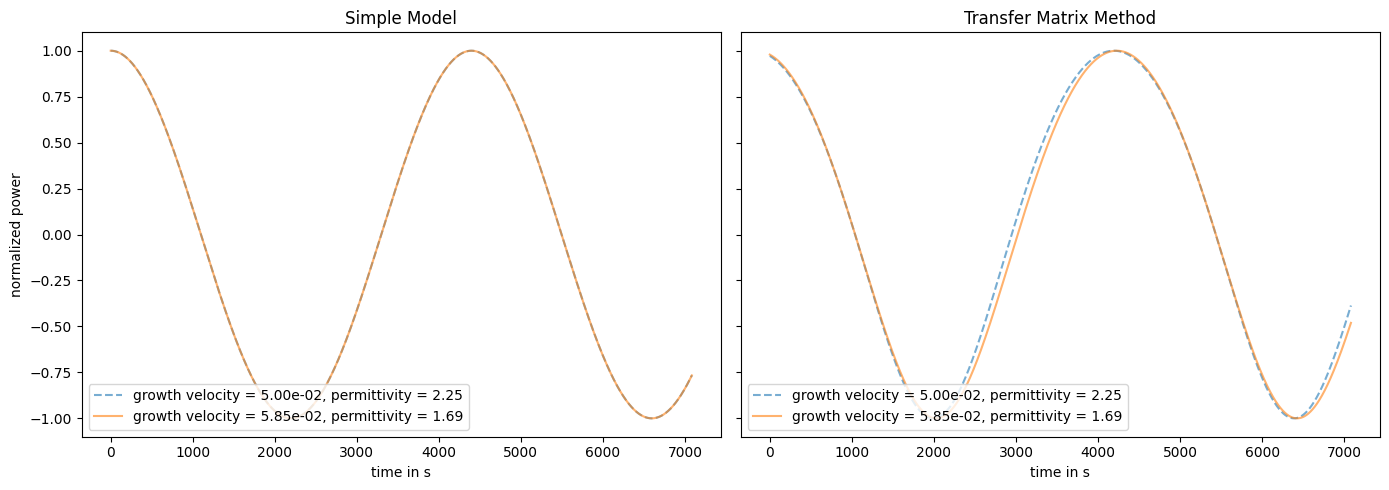

In [38]:
variable_layer_permittivity_A = 1.5**2
variable_layer_permittivity_B = 1.3**2

growth_velocity_A = 5e-2

def delta_var(variable_layer_permittivity):
    n0 = jnp.sqrt(optics_params.permeability_reflection * optics_params.permittivity_reflection)
    n1 = jnp.sqrt(variable_layer_params.permeabilities * variable_layer_permittivity)
    return jnp.sqrt(n1 ** 2 - n0 ** 2 * jnp.sin(setup_params.polar_angle) ** 2)

growth_velocity_B = growth_velocity_A * delta_var(variable_layer_permittivity_A) / delta_var(variable_layer_permittivity_B)

def run_model(model, growth_velocity, variable_layer_permittivity):
    return normalized_forward_model(
            model,
            setup_params = setup_params,
            optics_params = optics_params,
            static_layer_params = static_layer_params,
            variable_layer_params = variable_layer_params._replace(permittivities = variable_layer_permittivity),
            variable_layer_thicknesses = growth_velocity * time_points_measured,
            backside_mode = backside_mode
    )

simple_A = run_model(model = 0, growth_velocity = growth_velocity_A, variable_layer_permittivity = variable_layer_permittivity_A)
simple_B = run_model(model = 0, growth_velocity = growth_velocity_B, variable_layer_permittivity = variable_layer_permittivity_B)

tmm_A = run_model(model = 4, growth_velocity = growth_velocity_A, variable_layer_permittivity = variable_layer_permittivity_A)
tmm_B = run_model(model = 4, growth_velocity = growth_velocity_B, variable_layer_permittivity = variable_layer_permittivity_B)

# plot 1x2 with simple model on the left and tmm on the right
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 5))

ax1.plot(time_points_measured, simple_A, "--", alpha = 0.6, label="growth velocity = {:.2e}, permittivity = {:.2f}".format(growth_velocity_A, variable_layer_permittivity_A))
ax1.plot(time_points_measured, simple_B, "-", alpha = 0.6, label="growth velocity = {:.2e}, permittivity = {:.2f}".format(growth_velocity_B, variable_layer_permittivity_B))
ax1.legend(loc="lower left")

ax2.plot(time_points_measured, tmm_A, "--", alpha = 0.6, label="growth velocity = {:.2e}, permittivity = {:.2f}".format(growth_velocity_A, variable_layer_permittivity_A))
ax2.plot(time_points_measured, tmm_B, "-", alpha = 0.6, label="growth velocity = {:.2e}, permittivity = {:.2f}".format(growth_velocity_B, variable_layer_permittivity_B))
ax2.legend(loc="lower left")

ax1.set_title("Simple Model")
ax2.set_title("Transfer Matrix Method")

ax1.set_xlabel("time in s")
ax2.set_xlabel("time in s")
ax1.set_ylabel("normalized power")

plt.tight_layout()

plt.savefig("simple_vs_tmm.png", dpi=300)